In [0]:
!pip3 -qq install torch==0.4.1
!pip -qq install torchtext==0.3.1
!pip -qq install spacy==2.0.16
!pip -qq install torchvision==0.2.1
!python -m spacy download en
!pip install sacremoses==0.0.5
!pip install subword_nmt==0.3.5
!wget -qq http://www.manythings.org/anki/rus-eng.zip 
!unzip rus-eng.zip

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

np.random.seed(42)

# Attention

В прошлый раз мы реализовали простую Seq2seq модель:

![](https://raw.githubusercontent.com/tensorflow/nmt/master/nmt/g3doc/img/seq2seq.jpg =x400)  
*From [tensorflow/nmt](https://github.com/tensorflow/nmt)*

Основной её недостаток - вся информация об исходном тексте кодируется в единственный вектор фиксированного размера. Но очевидно же, что идея эта так себе.

Давайте запоминать все скрытые состояния энкодера, а не только последнее.

Дальше, для вычисления нового слова при генерации найдем сначала представление уже сгенерированного контекста (по которому обычно и генерируется следующее слово).  
По этому представлению посчитаем оценки полезности состояний энкодера: `attention weights` на картинке ниже. Чем выше вес - тем более полезно состояние. (Можно, кстати, представлять, что в предыдущем варианте мы просто давали всем состояниям кроме последнего вес 0, а последнему - 1).

С этими весами состояния энкодера суммируются, и мы получаем взвешенный вектор-представление контекста. Опять вектор?! Но теперь этот вектор получен для конкретного генерируемого слова - это же гораздо лучше, чем пытаться сделать один вектор сразу для всех генерируемых слов.

![attention](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg =x400)  
From [Neural Machine Translation (seq2seq) Tutorial](https://www.tensorflow.org/tutorials/seq2seq).

Более наглядно это может быть в [динамике](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/attention_mechanism.gif) (из cs224n + shad nlp course).

В результате получаются такие красивые картинки с визуализацией аттеншена:   
![att-vis](https://www.tensorflow.org/images/seq2seq/attention_vis.jpg =x500)

Яркость ячейки показывает насколько много внимания уделяла модель данному слову на исходном языке при генерации соответствующего ему слова.

Очень красивая статья с демонстрацией attention'а: [Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/).

## Подготовка

Возьмем те же данные, что и в прошлый раз:

In [0]:
!shuf -n 10 rus.txt

What should I give Tom for Christmas?	Что мне подарить Тому на Рождество?
Do you have any red wine?	У вас есть красное вино?
You can do that tomorrow.	Можешь сделать это завтра.
I made a fool of myself.	Я выставила себя на посмешище.
I have a slight fever today.	Сегодня у меня небольшая лихорадка.
I forgot to ask your name.	Я забыл спросить Ваше имя.
I thought Tom was your husband.	Я думал, Том - Ваш муж.
I've worked extremely hard.	Я трудился очень тяжело.
It is difficult for me.	Это для меня сложно.
I want you to say you're not going back to Boston.	Я хочу, чтобы ты сказала, что не возвращаешься в Бостон.


Токенизируем их:

In [0]:
from torchtext.data import Field, Example, Dataset, BucketIterator

BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

source_field = Field(tokenize='spacy', init_token=None, eos_token=EOS_TOKEN, lower=True)
target_field = Field(tokenize='moses', init_token=BOS_TOKEN, eos_token=EOS_TOKEN, lower=True)
fields = [('source', source_field), ('target', target_field)]

In [0]:
from tqdm import tqdm

MAX_TOKENS_COUNT = 16
SUBSET_SIZE = .3

examples = []
with open('rus.txt') as f:
    for line in tqdm(f, total=328190):
        source_text, target_text = line.split('\t')
        source_text = source_field.preprocess(source_text)
        target_text = target_field.preprocess(target_text)
        if len(source_text) <= MAX_TOKENS_COUNT and len(target_text) <= MAX_TOKENS_COUNT:
            if np.random.rand() < SUBSET_SIZE:
                examples.append(Example.fromlist([source_text, target_text], fields))

100%|██████████| 328190/328190 [00:59<00:00, 5516.49it/s]


Построим датасеты:

In [0]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

source_field.build_vocab(train_dataset, min_freq=2)
print('Source vocab size =', len(source_field.vocab))

target_field.build_vocab(train_dataset, min_freq=2)
print('Target vocab size =', len(target_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(32, 512), shuffle=True, device=DEVICE, sort=False
)

Train size = 83261
Test size = 14693
Source vocab size = 6311
Target vocab size = 14050


## Seq2seq модель

Старая модель выглядела так:

In [0]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1, bidirectional=False):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim, 
                           num_layers=num_layers, bidirectional=bidirectional)

    def forward(self, inputs, hidden=None):
        """
        input: LongTensor with shape (encoder_seq_len, batch_size)
        hidden: FloatTensor with shape (1, batch_size, rnn_hidden_dim)
        """
        encoder_output, encoder_hidden = self._rnn(self._emb(inputs), hidden)
        return encoder_output, encoder_hidden

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, attn_dim=128, num_layers=1):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Linear(rnn_hidden_dim, vocab_size)

    def forward(self, inputs, encoder_output, encoder_mask, hidden=None):
        """
        input: LongTensor with shape (decoder_seq_len, batch_size)
        encoder_output: FloatTensor with shape (encoder_seq_len, batch_size, rnn_hidden_dim)
        encoder_mask: ByteTensor with shape (encoder_seq_len, batch_size) (ones in positions of <pad> tokens, zeros everywhere else)
        hidden: FloatTensor with shape (1, batch_size, rnn_hidden_dim)
        """
        embs = self._emb(inputs)
        outputs = []
        for i in range(embs.shape[0]):
            output, hidden = self._rnn(embs[i: i+1], hidden)

            outputs.append(output)

        output = torch.cat(outputs)
        return self._out(output), hidden

## Реализация attention'а

В общем случае, attention работает так: пусть у нас есть набор скрытых состояний $\mathbf{s}_1, \ldots, \mathbf{s}_m$ - представлений слов из исходного языка, полученных с помощью энкодера. И есть некоторое текущее скрытое состояние $\mathbf{h}_i$ - скажем, представление, используемое для предсказания слова на нужном нам языке.

Тогда с помощью аттеншена мы можем получить взвешенное представление контекста $\mathbf{s}_1, \ldots, \mathbf{s}_m$ - вектор $\mathbf{c}_i$:
$$
\begin{align}\begin{split}
\mathbf{c}_i &= \sum\limits_j a_{ij}\mathbf{s}_j\\
\mathbf{a}_{ij} &= \text{softmax}(f_{att}(\mathbf{h}_i, \mathbf{s}_j))
\end{split}\end{align}
$$

$f_{att}$ - функция, которая говорит, насколько хорошо $\mathbf{h}_i$ и $\mathbf{s}_j$ подходят друг другу.

Самые популярные её варианты:
- Additive attention:
$$f_{att}(\mathbf{h}_i, \mathbf{s}_j) = \mathbf{v}_a{}^\top \text{tanh}(\mathbf{W}_a\mathbf{h}_i + \mathbf{W}_b\mathbf{s}_j)$$
- Dot attention:
$$f_{att}(\mathbf{h}_i, \mathbf{s}_j) = \mathbf{h}_i^\top \mathbf{s}_j$$
- Multiplicative attention:
$$f_{att}(\mathbf{h}_i, \mathbf{s}_j) = \mathbf{h}_i^\top \mathbf{W}_a \mathbf{s}_j$$

**Задание** Реализуйте Additive attention.

In [0]:
class AdditiveAttention(nn.Module):
    def __init__(self, query_size, key_size, hidden_dim):
        super().__init__()

        self._query_layer = nn.Linear(query_size, hidden_dim)
        self._key_layer = nn.Linear(key_size, hidden_dim)
        self._energy_layer = nn.Linear(hidden_dim, 1)

    def forward(self, query, key, value, mask):
        """
        query: FloatTensor with shape (batch_size, query_size) (h_i)
        key: FloatTensor with shape (encoder_seq_len, batch_size, key_size) (sequence of s_1, ..., s_m)
        value: FloatTensor with shape (encoder_seq_len, batch_size, key_size) (sequence of s_1, ..., s_m)
        mask: ByteTensor with shape (encoder_seq_len, batch_size) (ones in positions of <pad> tokens, zeros everywhere else)
        """
        f_att = self._energy_layer(torch.tanh(self._query_layer(query) + self._key_layer(key)))
        f_att.data.masked_fill_(mask.unsqueeze(2), -float('inf'))
        weights = F.softmax(f_att, 0)
        return (weights * value).sum(0), weights

Нужно обновить `Decoder`, чтобы он работал с attention'ом:  
![](https://image.ibb.co/fB12nq/2018-11-12-23-34-06.png =x500)  
*From [Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/#attentional-interfaces)*

На каждом шаге rnn'ки будем использовать текущее скрытое состояние декодера, чтобы определить, какие из состояний энкодера самые интересные.

Выход attention'а (текущий контекст) будем конкатенировать к эмбеддингу слова.

**Задание** Обновите `Decoder`.

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, attn_dim=128, num_layers=1):
        super().__init__()

        self._o0 = nn.Linear(2 * rnn_hidden_dim, rnn_hidden_dim)
        self._h0 = nn.Linear(2 * rnn_hidden_dim, rnn_hidden_dim)

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._attention = AdditiveAttention(rnn_hidden_dim, rnn_hidden_dim, attn_dim)
        self._rnn = nn.GRU(input_size=emb_dim + rnn_hidden_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Linear(rnn_hidden_dim, vocab_size)

    def forward(self, inputs, encoder_output, encoder_mask, encoder_hidden, output=None, hidden=None):
        """
        input: LongTensor with shape (decoder_seq_len, batch_size)
        encoder_output: FloatTensor with shape (encoder_seq_len, batch_size, rnn_hidden_dim)
        encoder_mask: ByteTensor with shape (encoder_seq_len, batch_size) (ones in positions of <pad> tokens, zeros everywhere else)
        hidden: FloatTensor with shape (1, batch_size, rnn_hidden_dim)
        """
        if hidden is None:
            hidden = self.init_hidden(encoder_hidden)

        if output is None:
            output = self._o0(encoder_output)

        embs = self._emb(inputs)
        outputs, attentions = [], []

        for i in range(embs.shape[0]):
            context, weights = self._attention(query=hidden, key=output, value=output, mask=encoder_mask)
            context = context.unsqueeze(0)
            rnn_input = torch.cat((embs[i: i+1], context), -1)
            out, hidden = self._rnn(rnn_input, hidden)

            outputs.append(out)
            attentions.append(weights)

        out = torch.cat(outputs)
        attention = torch.cat(attentions)
        return self._out(out), hidden, attention

    def init_hidden(self, encoder_hidden):
        encoder_hidden = torch.cat((encoder_hidden[0], encoder_hidden[1]), -1).unsqueeze(0)
        return self._h0(encoder_hidden)

In [0]:
batch = next(iter(train_iter))

Модель перевода будет просто сперва вызывать Encoder, а потом передавать его скрытое состояние декодеру в качестве начального.

In [0]:
class TranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=64, rnn_hidden_dim=128, 
                 attn_dim=128, num_layers=1, bidirectional_encoder=False):

        super().__init__()
        self._bidirectional = bidirectional_encoder

        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = Decoder(target_vocab_size, emb_dim, rnn_hidden_dim, attn_dim, num_layers)

    def forward(self, source_inputs, target_inputs):
        encoder_mask = source_inputs == 1.  # find mask for padding inputs
        encoder_output, encoder_hidden = self.encoder(source_inputs)

        output = encoder_output
        hidden = encoder_hidden
        if self._bidirectional:
            hidden = None
            output = None

        return self.decoder(target_inputs, encoder_output, encoder_mask, encoder_hidden, output, hidden)

In [0]:
model = TranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab)).to(DEVICE)

model(batch.source, batch.target)

(tensor([[[ 0.0013,  0.1662,  0.1710,  ..., -0.2824,  0.1270, -0.3437],
          [ 0.0027,  0.1552,  0.1885,  ..., -0.2591,  0.1533, -0.3434],
          [-0.0060,  0.1459,  0.1994,  ..., -0.2955,  0.1460, -0.3381],
          ...,
          [-0.0076,  0.1514,  0.1804,  ..., -0.2606,  0.1680, -0.3314],
          [-0.0191,  0.1569,  0.2063,  ..., -0.2616,  0.1605, -0.3326],
          [-0.0100,  0.1401,  0.1867,  ..., -0.2744,  0.1532, -0.3156]],
 
         [[ 0.0662,  0.4134, -0.0666,  ..., -0.0418,  0.2967, -0.1195],
          [ 0.0533,  0.0696,  0.2292,  ..., -0.0893,  0.1327, -0.2534],
          [ 0.2139,  0.0934,  0.3555,  ..., -0.1599,  0.0915, -0.1295],
          ...,
          [ 0.2127, -0.0945,  0.1777,  ..., -0.1426,  0.1518, -0.2243],
          [-0.0366,  0.2779,  0.3116,  ..., -0.2151,  0.3526, -0.1155],
          [-0.0354,  0.2655,  0.2813,  ..., -0.2211,  0.3455, -0.0902]],
 
         [[ 0.1126,  0.1358,  0.0503,  ..., -0.1634,  0.1209, -0.2108],
          [-0.0145, -0.0288,

## Тренировка модели

In [0]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(model, iterator):
    model.eval()
    refs, hyps = [], []
    bos_index = iterator.dataset.fields['target'].vocab.stoi[BOS_TOKEN]
    eos_index = iterator.dataset.fields['target'].vocab.stoi[EOS_TOKEN]
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            encoder_output, encoder_hidden = model.encoder(batch.source)
            mask = batch.source == 1.
            
            output = encoder_output
            hidden = encoder_hidden
            if model._bidirectional:
                output = None
                hidden = None
            
            result = [LongTensor([bos_index]).expand(1, batch.target.shape[1])]
            
            for _ in range(30):
                step, hidden, _ = model.decoder(result[-1], encoder_output, mask, encoder_hidden, output, hidden)
                step = step.argmax(-1)
                result.append(step)
            
            targets = batch.target.data.cpu().numpy().T
            eos_indices = (targets == eos_index).argmax(-1)
            eos_indices[eos_indices == 0] = targets.shape[1]

            targets = [target[:eos_ind] for eos_ind, target in zip(eos_indices, targets)]
            refs.extend(targets)
            
            result = torch.cat(result)
            result = result.data.cpu().numpy().T
            eos_indices = (result == eos_index).argmax(-1)
            eos_indices[eos_indices == 0] = result.shape[1]

            result = [res[:eos_ind] for eos_ind, res in zip(eos_indices, result)]
            hyps.extend(result)
            
    return corpus_bleu([[ref] for ref in refs], hyps) * 100

In [0]:
evaluate_model(model, test_iter)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


42.466132707889706

In [0]:
import math
from tqdm import tqdm
tqdm.get_lock().locks = []


def do_epoch(model, criterion, data_iter, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):                
                logits, _, _ = model(batch.source, batch.target)
                
                target = torch.cat((batch.target[1:], batch.target.new_ones((1, batch.target.shape[1]))))
                loss = criterion(logits.view(-1, logits.shape[-1]), target.view(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None):
    best_val_loss = None
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, None, name_prefix + '  Val:')
            print('\nVal BLEU = {:.2f}'.format(evaluate_model(model, val_iter)))

In [0]:
model = TranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab)).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=10, val_iter=test_iter)

  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 20.14


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 26.67


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 30.03


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 31.66


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 32.99


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 34.03


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 34.52


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 34.73


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 35.21


[10 / 10]   Val: Loss = 1.66174, PPX = 5.27: 100%|██████████| 29/29 [00:02<00:00, 10.94it/s]



Val BLEU = 35.57


## Визуализация результатов

In [0]:
def greedy_decode(model, source_text, source_field, target_field):
    bos_index = target_field.vocab.stoi[BOS_TOKEN]
    eos_index = target_field.vocab.stoi[EOS_TOKEN]
    
    model.eval()
    with torch.no_grad():
        result, attentions = [], []
        source = source_field.preprocess(source_text)
        inputs = source_field.process([source]).to(DEVICE)
        
        encoder_output, encoder_hidden = model.encoder(inputs)
        encoder_mask = torch.zeros_like(inputs).byte()
        
        output = encoder_output
        hidden = encoder_hidden
        if model._bidirectional:
            output = None
            hidden = None
        
        step = LongTensor([[bos_index]])
        
        for _ in range(50):
            step, hidden, attention = model.decoder(step, encoder_output, encoder_mask, encoder_hidden, output, hidden)
            step = step.argmax(-1)
            attentions.append(attention.squeeze(1))
          
            if step.squeeze().item() == eos_index:
                break
            
            result.append(step.item())   
        result = [target_field.vocab.itos[ind] for ind in result]
        return source, result, torch.cat(attentions, -1).data.cpu().numpy()

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')

    ax.set_xticklabels(trg, minor=False, rotation=45)
    ax.set_yticklabels(src, minor=False)

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

In [0]:
source, result, attentions = greedy_decode(model, "I didn't pay.", source_field, target_field)

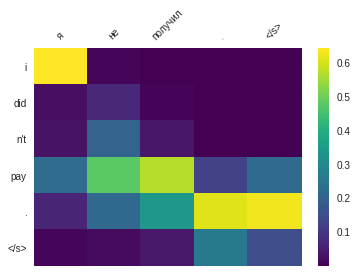

In [0]:
plot_heatmap(source + ['</s>'], result + ['</s>'], attentions)

## Улучшение модели

**Задание** Попробуйте другие варианты attention'а (из приведенных выше).

In [0]:
class DotAttention(nn.Module):
    def forward(self, query, key, value, mask):
        """
        query: FloatTensor with shape (batch_size, query_size) (h_i)
        key: FloatTensor with shape (encoder_seq_len, batch_size, key_size) (sequence of s_1, ..., s_m)
        value: FloatTensor with shape (encoder_seq_len, batch_size, key_size) (sequence of s_1, ..., s_m)
        mask: ByteTensor with shape (encoder_seq_len, batch_size) (ones in positions of <pad> tokens, zeros everywhere else)
        """
        f_att = torch.matmul(query, key.transpose(-2, -1))
        f_att.data.masked_fill_(mask.unsqueeze(-2), -float('inf'))
        weights = F.softmax(f_att, -1)
        output = torch.matmul(weights, value)
        return output.sum(0), weights

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, attn_dim=128, num_layers=1):
        super().__init__()

        self._o0 = nn.Linear(2 * rnn_hidden_dim, rnn_hidden_dim)
        self._h0 = nn.Linear(2 * rnn_hidden_dim, rnn_hidden_dim)

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._attention = DotAttention()
        self._rnn = nn.GRU(input_size=emb_dim + rnn_hidden_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Linear(rnn_hidden_dim, vocab_size)

    def forward(self, inputs, encoder_output, encoder_mask, encoder_hidden, output=None, hidden=None):
        """
        input: LongTensor with shape (decoder_seq_len, batch_size)
        encoder_output: FloatTensor with shape (encoder_seq_len, batch_size, rnn_hidden_dim)
        encoder_mask: ByteTensor with shape (encoder_seq_len, batch_size) (ones in positions of <pad> tokens, zeros everywhere else)
        hidden: FloatTensor with shape (1, batch_size, rnn_hidden_dim)
        """
        if hidden is None:
            hidden = self.init_hidden(encoder_hidden)

        if output is None:
            output = self._o0(encoder_output)

        embs = self._emb(inputs)
        outputs, attentions = [], []

        for i in range(embs.shape[0]):
            context, weights = self._attention(query=hidden, key=output, value=output, mask=encoder_mask)
            context = context.unsqueeze(0)
            rnn_input = torch.cat((embs[i: i+1], context), -1)
            out, hidden = self._rnn(rnn_input, hidden)

            outputs.append(out)
            attentions.append(weights)

        out = torch.cat(outputs)
        attention = torch.cat(attentions)
        return self._out(out), hidden, attention

    def init_hidden(self, encoder_hidden):
        encoder_hidden = torch.cat((encoder_hidden[0], encoder_hidden[1]), -1).unsqueeze(0)
        return self._h0(encoder_hidden)

In [0]:
class TranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=64, rnn_hidden_dim=128, 
                 attn_dim=128, num_layers=1, bidirectional_encoder=False):

        super().__init__()
        self._bidirectional = bidirectional_encoder

        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = Decoder(target_vocab_size, emb_dim, rnn_hidden_dim, attn_dim, num_layers)

    def forward(self, source_inputs, target_inputs):
        encoder_mask = source_inputs == 1.  # find mask for padding inputs
        encoder_output, encoder_hidden = self.encoder(source_inputs)

        output = encoder_output
        hidden = encoder_hidden
        if self._bidirectional:
            hidden = None
            output = None

        return self.decoder(target_inputs, encoder_output, encoder_mask, encoder_hidden, output, hidden)

In [0]:
model = TranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab)).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=10, val_iter=test_iter)

  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 8.69


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 14.34


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 17.33


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 18.96


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 20.42


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 21.27


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 22.45


[9 / 10] Train: Loss = 1.31296, PPX = 3.72:   0%|          | 1/2602 [00:00<08:06,  5.35it/s]


Val BLEU = 22.56


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 23.72


[10 / 10]   Val: Loss = 2.04168, PPX = 7.70: 100%|██████████| 29/29 [00:03<00:00,  9.04it/s]



Val BLEU = 24.56


In [0]:
source, result, attentions = greedy_decode(model, "I didn't pay.", source_field, target_field)

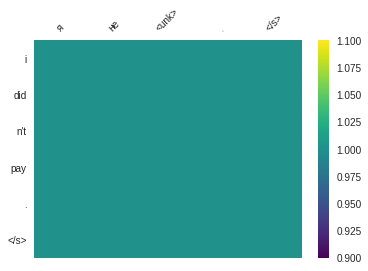

In [0]:
plot_heatmap(source + ['</s>'], result + ['</s>'], attentions)

In [0]:
class MultiplicativeAttention(nn.Module):
    def __init__(self, key_size, hidden_dim):
        super().__init__()
        
        self._key_layer = nn.Linear(key_size, hidden_dim)
        
    def forward(self, query, key, value, mask):
        """
        query: FloatTensor with shape (batch_size, query_size) (h_i)
        key: FloatTensor with shape (encoder_seq_len, batch_size, key_size) (sequence of s_1, ..., s_m)
        value: FloatTensor with shape (encoder_seq_len, batch_size, key_size) (sequence of s_1, ..., s_m)
        mask: ByteTensor with shape (encoder_seq_len, batch_size) (ones in positions of <pad> tokens, zeros everywhere else)
        """
        f_att = torch.matmul(query, self._key_layer(key).transpose(-2, -1))
        f_att.data.masked_fill_(mask.unsqueeze(-2), -float('inf'))
        weights = F.softmax(f_att, -1)
        output = torch.matmul(weights, value)
        return output.sum(0), weights

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, attn_dim=128, num_layers=1):
        super().__init__()

        self._o0 = nn.Linear(2 * rnn_hidden_dim, rnn_hidden_dim)
        self._h0 = nn.Linear(2 * rnn_hidden_dim, rnn_hidden_dim)

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._attention = MultiplicativeAttention(rnn_hidden_dim, attn_dim)
        self._rnn = nn.GRU(input_size=emb_dim + rnn_hidden_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Linear(rnn_hidden_dim, vocab_size)

    def forward(self, inputs, encoder_output, encoder_mask, encoder_hidden, output=None, hidden=None):
        """
        input: LongTensor with shape (decoder_seq_len, batch_size)
        encoder_output: FloatTensor with shape (encoder_seq_len, batch_size, rnn_hidden_dim)
        encoder_mask: ByteTensor with shape (encoder_seq_len, batch_size) (ones in positions of <pad> tokens, zeros everywhere else)
        hidden: FloatTensor with shape (1, batch_size, rnn_hidden_dim)
        """
        if hidden is None:
            hidden = self.init_hidden(encoder_hidden)

        if output is None:
            output = self._o0(encoder_output)

        embs = self._emb(inputs)
        outputs, attentions = [], []

        for i in range(embs.shape[0]):
            context, weights = self._attention(query=hidden, key=output, value=output, mask=encoder_mask)
            context = context.unsqueeze(0)
            rnn_input = torch.cat((embs[i: i+1], context), -1)
            out, hidden = self._rnn(rnn_input, hidden)

            outputs.append(out)
            attentions.append(weights)

        out = torch.cat(outputs)
        attention = torch.cat(attentions)
        return self._out(out), hidden, attention

    def init_hidden(self, encoder_hidden):
        encoder_hidden = torch.cat((encoder_hidden[0], encoder_hidden[1]), -1).unsqueeze(0)
        return self._h0(encoder_hidden)

In [0]:
class TranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=64, rnn_hidden_dim=128, 
                 attn_dim=128, num_layers=1, bidirectional_encoder=False):

        super().__init__()
        self._bidirectional = bidirectional_encoder

        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = Decoder(target_vocab_size, emb_dim, rnn_hidden_dim, attn_dim, num_layers)

    def forward(self, source_inputs, target_inputs):
        encoder_mask = source_inputs == 1.  # find mask for padding inputs
        encoder_output, encoder_hidden = self.encoder(source_inputs)

        output = encoder_output
        hidden = encoder_hidden
        if self._bidirectional:
            hidden = None
            output = None

        return self.decoder(target_inputs, encoder_output, encoder_mask, encoder_hidden, output, hidden)

In [0]:
model = TranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab)).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=10, val_iter=test_iter)

  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 7.97


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 12.59


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 15.84


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 17.73


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 19.39


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 20.55


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 22.16


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 22.69


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 23.39


[10 / 10]   Val: Loss = 2.07622, PPX = 7.97: 100%|██████████| 29/29 [00:03<00:00,  8.46it/s]



Val BLEU = 23.63


In [0]:
source, result, attentions = greedy_decode(model, "I didn't pay.", source_field, target_field)

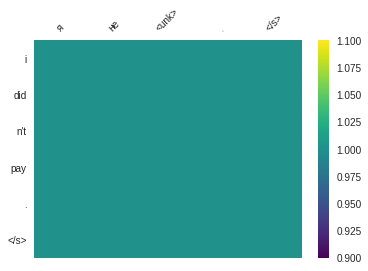

In [0]:
plot_heatmap(source + ['</s>'], result + ['</s>'], attentions)

**Задание** Попробуйте приемы из тех, что были в предыдущем ноутбуке: bpe, dropout, bidirectional or multi-layer encoder.

#### SImple model w/ bidirectional encoder

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, attn_dim=128, num_layers=1):
        super().__init__()

        self._o0 = nn.Linear(2 * rnn_hidden_dim, rnn_hidden_dim)
        self._h0 = nn.Linear(2 * rnn_hidden_dim, rnn_hidden_dim)

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._attention = AdditiveAttention(rnn_hidden_dim, rnn_hidden_dim, attn_dim)
        self._rnn = nn.GRU(input_size=emb_dim + rnn_hidden_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Linear(rnn_hidden_dim, vocab_size)

    def forward(self, inputs, encoder_output, encoder_mask, encoder_hidden, output=None, hidden=None):
        """
        input: LongTensor with shape (decoder_seq_len, batch_size)
        encoder_output: FloatTensor with shape (encoder_seq_len, batch_size, rnn_hidden_dim)
        encoder_mask: ByteTensor with shape (encoder_seq_len, batch_size) (ones in positions of <pad> tokens, zeros everywhere else)
        hidden: FloatTensor with shape (1, batch_size, rnn_hidden_dim)
        """
        if hidden is None:
            hidden = self.init_hidden(encoder_hidden)

        if output is None:
            output = self._o0(encoder_output)

        embs = self._emb(inputs)
        outputs, attentions = [], []

        for i in range(embs.shape[0]):
            context, weights = self._attention(query=hidden, key=output, value=output, mask=encoder_mask)
            context = context.unsqueeze(0)
            rnn_input = torch.cat((embs[i: i+1], context), -1)
            out, hidden = self._rnn(rnn_input, hidden)

            outputs.append(out)
            attentions.append(weights)

        out = torch.cat(outputs)
        attention = torch.cat(attentions)
        return self._out(out), hidden, attention

    def init_hidden(self, encoder_hidden):
        encoder_hidden = torch.cat((encoder_hidden[0], encoder_hidden[1]), -1).unsqueeze(0)
        return self._h0(encoder_hidden)

In [0]:
class TranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=64, rnn_hidden_dim=128, 
                 attn_dim=128, num_layers=1, bidirectional_encoder=False):

        super().__init__()
        self._bidirectional = bidirectional_encoder

        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = Decoder(target_vocab_size, emb_dim, rnn_hidden_dim, attn_dim, num_layers)

    def forward(self, source_inputs, target_inputs):
        encoder_mask = source_inputs == 1.  # find mask for padding inputs
        encoder_output, encoder_hidden = self.encoder(source_inputs)

        output = encoder_output
        hidden = encoder_hidden
        if self._bidirectional:
            hidden = None
            output = None

        return self.decoder(target_inputs, encoder_output, encoder_mask, encoder_hidden, output, hidden)

In [0]:
model = TranslationModel(source_vocab_size=len(source_field.vocab),
                         target_vocab_size=len(target_field.vocab),
                         bidirectional_encoder=True).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=10, val_iter=test_iter)

  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 21.13


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 27.15


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 30.16


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 31.59


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 32.34


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 33.03


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 33.62


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 34.14


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 34.25


[10 / 10]   Val: Loss = 1.75233, PPX = 5.77: 100%|██████████| 29/29 [00:02<00:00, 10.78it/s]



Val BLEU = 34.27


#### Heavy model w/ additional layers

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, attn_dim=128, num_layers=1):
        super().__init__()

        self._o0 = nn.Linear(2 * rnn_hidden_dim, rnn_hidden_dim)
        self._h0 = nn.Linear(2 * rnn_hidden_dim, rnn_hidden_dim)
        
        self._dropout = nn.Dropout()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._attention = AdditiveAttention(rnn_hidden_dim, rnn_hidden_dim, attn_dim)
        self._rnn = nn.GRU(input_size=emb_dim + rnn_hidden_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out_1 = nn.Linear(rnn_hidden_dim, 2 * rnn_hidden_dim)
        self._out_2 = nn.Linear(2 * rnn_hidden_dim, vocab_size)

    def forward(self, inputs, encoder_output, encoder_mask, encoder_hidden, output=None, hidden=None):
        """
        input: LongTensor with shape (decoder_seq_len, batch_size)
        encoder_output: FloatTensor with shape (encoder_seq_len, batch_size, rnn_hidden_dim)
        encoder_mask: ByteTensor with shape (encoder_seq_len, batch_size) (ones in positions of <pad> tokens, zeros everywhere else)
        hidden: FloatTensor with shape (1, batch_size, rnn_hidden_dim)
        """
        if hidden is None:
            hidden = self.init_hidden(encoder_hidden)

        if output is None:
            output = self._o0(encoder_output)

        embs = self._emb(inputs)
        outputs, attentions = [], []

        for i in range(embs.shape[0]):
            context, weights = self._attention(query=hidden, key=output, value=output, mask=encoder_mask)
            context = context.unsqueeze(0)
            rnn_input = torch.cat((embs[i: i+1], context), -1)
            out, hidden = self._rnn(rnn_input, hidden)

            outputs.append(out)
            attentions.append(weights)

        out = torch.cat(outputs)
        attention = torch.cat(attentions)
        return self._out_2(self._out_1((self._dropout(out)))), hidden, attention

    def init_hidden(self, encoder_hidden):
        encoder_hidden = torch.cat((encoder_hidden[0], encoder_hidden[1]), -1).unsqueeze(0)
        return self._h0(encoder_hidden)

In [0]:
class TranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=64, rnn_hidden_dim=128, 
                 attn_dim=128, num_layers=1, bidirectional_encoder=False):

        super().__init__()
        self._bidirectional = bidirectional_encoder

        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = Decoder(target_vocab_size, emb_dim, rnn_hidden_dim, attn_dim, num_layers)

    def forward(self, source_inputs, target_inputs):
        encoder_mask = source_inputs == 1.  # find mask for padding inputs
        encoder_output, encoder_hidden = self.encoder(source_inputs)

        output = encoder_output
        hidden = encoder_hidden
        if self._bidirectional:
            hidden = None
            output = None

        return self.decoder(target_inputs, encoder_output, encoder_mask, encoder_hidden, output, hidden)

In [0]:
model = TranslationModel(source_vocab_size=len(source_field.vocab),
                         target_vocab_size=len(target_field.vocab),
                         bidirectional_encoder=True).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=10, val_iter=test_iter)

  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 21.31


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 27.45


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 31.01


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 32.62


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 34.46


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 34.63


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 35.70


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 37.01


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 37.14


[10 / 10]   Val: Loss = 1.52413, PPX = 4.59: 100%|██████████| 29/29 [00:03<00:00,  9.93it/s]



Val BLEU = 37.75


#### Previous model & BPE

In [0]:
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

with open('data.en', 'w') as f_src, open('data.ru', 'w') as f_dst:
    for example in examples:
        f_src.write(' '.join(example.source) + '\n')
        f_dst.write(' '.join(example.target) + '\n')

bpe = {}
for lang in ['en', 'ru']:
    with open('./data.' + lang) as f_data, open('bpe_rules.' + lang, 'w') as f_rules:
        learn_bpe(f_data, f_rules, num_symbols=3000)
    with open('bpe_rules.' + lang) as f_rules:
        bpe[lang] = BPE(f_rules)

In [0]:
from torchtext.data import Field, Example, Dataset, BucketIterator

BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

source_field = Field(tokenize='spacy', init_token=None, eos_token=EOS_TOKEN)
target_field = Field(tokenize='moses', init_token=BOS_TOKEN, eos_token=EOS_TOKEN)
fields = [('source', source_field), ('target', target_field)]

In [0]:
from tqdm import tqdm

MAX_TOKENS_COUNT = 16
SUBSET_SIZE = .3

examples = []
with open('rus.txt') as f:
    for line in tqdm(f, total=328190):
        source_text, target_text = line.split('\t')
        source_text = bpe['en'].segment_tokens(source_field.preprocess(source_text))
        target_text = bpe['ru'].segment_tokens(target_field.preprocess(target_text))
        if len(source_text) <= MAX_TOKENS_COUNT and len(target_text) <= MAX_TOKENS_COUNT:
            if np.random.rand() < SUBSET_SIZE:
                examples.append(Example.fromlist([source_text, target_text], fields))

100%|██████████| 328190/328190 [01:16<00:00, 4274.35it/s]


In [0]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

source_field.build_vocab(train_dataset, min_freq=3)
print('Source vocab size =', len(source_field.vocab))

target_field.build_vocab(train_dataset, min_freq=3)
print('Target vocab size =', len(target_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(32, 256), shuffle=True, device=DEVICE, sort=False
)

Train size = 79163
Test size = 13970
Source vocab size = 2905
Target vocab size = 3064


In [0]:
model = TranslationModel(source_vocab_size=len(source_field.vocab),
                         target_vocab_size=len(target_field.vocab),
                         bidirectional_encoder=True).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=10, val_iter=test_iter)

  0%|          | 0/2474 [00:00<?, ?it/s]


Val BLEU = 21.44


  0%|          | 0/2474 [00:00<?, ?it/s]


Val BLEU = 26.22


  0%|          | 0/2474 [00:00<?, ?it/s]


Val BLEU = 29.08


  0%|          | 0/2474 [00:00<?, ?it/s]


Val BLEU = 30.58


  0%|          | 0/2474 [00:00<?, ?it/s]


Val BLEU = 31.70


  0%|          | 0/2474 [00:00<?, ?it/s]


Val BLEU = 32.47


  0%|          | 0/2474 [00:00<?, ?it/s]


Val BLEU = 32.78


  0%|          | 0/2474 [00:00<?, ?it/s]


Val BLEU = 33.22


  0%|          | 0/2474 [00:00<?, ?it/s]


Val BLEU = 34.23


[10 / 10]   Val: Loss = 1.72858, PPX = 5.63: 100%|██████████| 55/55 [00:02<00:00, 18.44it/s]



Val BLEU = 34.45


# Image Captioning with Attention

Attention может работать не только для текстов. Мы вполне можем аттентиться и на картинки:

![](https://cdn-images-1.medium.com/max/2000/0*YCeQbqU6CVxzpave.)  
*From [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044)*

В качестве энкодера будет выступать сверточная сеть. Модель теперь должна научиться генерировать маску внимания на каждом шаге:

![](http://kelvinxu.github.io/projects/diags/model_diag.png =x300)  
*From [http://kelvinxu.github.io/projects/capgen.html](http://kelvinxu.github.io/projects/capgen.html)*

Скачаем данные:

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1qM6fJuaOqhTES17kU_rz9Ydxz540bSJ6'})
downloaded.GetContentFile('image_codes_for_attn.npy')

downloaded = drive.CreateFile({'id': '1O7_3lyTyBMXsBBIt1PwUXwLdkyRQzZML'})
downloaded.GetContentFile('sources.txt')

downloaded = drive.CreateFile({'id': '1t-Dy8TzoRuTMoM7N9NJZKgWXfaw3b6KF'})
downloaded.GetContentFile('texts.txt')

!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
!unzip Flickr8k_Dataset.zip

In [0]:
# Some stuff from the Internet to make things work
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

Скачаем модель сверточной сети (чтобы было)

In [0]:
from torchvision.models.inception import Inception3
from torch.utils.model_zoo import load_url


class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        x = x.clone()
        x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
        x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
        x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    

inception_model = BeheadedInception3()

inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
inception_model.load_state_dict(load_url(inception_url))

inception_model.eval()

Загрузим данные:

In [0]:
target_field = Field(init_token=BOS_TOKEN, eos_token=EOS_TOKEN)
image_indices_field = Field(sequential=False, use_vocab=False)

fields = [('target', target_field), ('image_index', image_indices_field)]

Чтобы не уткнуться в лимит по памяти - используем memmap формат:

In [0]:
with open('sources.txt') as f_sources:
    image_paths = [line.strip() for line in f_sources]
    
image_tensors = np.memmap('image_codes_for_attn.npy', shape=(8091, 2048, 8, 8), dtype=np.float32)

examples = []
with open('texts.txt') as f_texts:
    for image_ind, texts in enumerate(f_texts):
        for text in texts.split('\t'):
            examples.append(Example.fromlist([target_field.preprocess(text), image_ind], fields))

In [0]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

target_field.build_vocab(train_dataset, min_freq=2)
print('Target vocab size =', len(target_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(16, 64), shuffle=True, device=DEVICE, sort=False
)

Train size = 41264
Test size = 7282
Target vocab size = 4870


**Задание** Реализуйте почти такие же модели как для перевода, чтобы научиться подписывать картинки:

In [0]:
class AdditiveAttention(nn.Module):
    def __init__(self, query_size, key_size, hidden_dim):
        super().__init__()

        self._query_layer = nn.Linear(query_size, hidden_dim)
        self._key_layer = nn.Linear(key_size, hidden_dim)
        self._energy_layer = nn.Linear(hidden_dim, 1)

    def forward(self, query, key, value):
        f_att = self._energy_layer(torch.tanh(self._query_layer(query) + self._key_layer(key.transpose(0, 1))))
        weights = F.softmax(f_att, 0)
        return (weights * value.transpose(0, 1)).sum(0), weights

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, cnn_feature_size, emb_dim=128, rnn_hidden_dim=256, attn_dim=128, num_layers=1):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._attention = AdditiveAttention(query_size=rnn_hidden_dim, key_size=cnn_feature_size, hidden_dim=attn_dim)
        
        self._cnn_to_h0 = nn.Linear(cnn_feature_size, rnn_hidden_dim)
        self._cnn_to_c0 = nn.Linear(cnn_feature_size, rnn_hidden_dim)
        self._rnn = nn.LSTM(input_size=emb_dim + cnn_feature_size, hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Linear(rnn_hidden_dim, vocab_size)

    def forward(self, encoder_output, inputs, hidden=None):
        embs = self._emb(inputs)
        
        seq_len, batch_size = inputs.shape[:2]
        
        encoder_output = encoder_output.view(batch_size, encoder_output.shape[1], -1).permute(0, 2, 1)
        
        if hidden is None:
            hidden = self.init_hidden(encoder_output)
        
        outputs, attentions = [], []
        
        for i in range(embs.shape[0]):
            context, weights = self._attention(query=hidden[0], key=encoder_output, value=encoder_output)
            context = context.unsqueeze(0)
            rnn_input = torch.cat((embs[i: i+1], context), -1)
            output, hidden = self._rnn(rnn_input, hidden)

            outputs.append(output)
            attentions.append(weights)
        
        output = torch.cat(outputs)
        attention = torch.cat(attentions)
    
        return self._out(output), hidden, attention
    
    def init_hidden(self, encoder_output):
        encoder_output = encoder_output.mean(dim=1)
        h0 = self._cnn_to_h0(encoder_output)
        c0 = self._cnn_to_c0(encoder_output)
        
        return h0.unsqueeze(0), c0.unsqueeze(0)

In [0]:
def do_epoch(model, criterion, data_iter, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):  
                encoder_output = FloatTensor(image_tensors[batch.image_index])
                logits, _, _ = model(encoder_output, batch.target)
                
                target = torch.cat((batch.target[1:], batch.target.new_ones((1, batch.target.shape[1]))))
                loss = criterion(logits.view(-1, logits.shape[-1]), target.view(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None):
    best_val_loss = None
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, None, name_prefix + '  Val:')

In [0]:
model = Decoder(vocab_size=len(target_field.vocab), cnn_feature_size=image_tensors.shape[1]).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=10, val_iter=test_iter)

[3 / 3]   Val: Loss = 2.65121, PPX = 14.17: 100%|██████████| 114/114 [00:32<00:00,  3.42it/s]


**Задание** Напишите цикл генерации по картинке:

In [0]:
def sample(probs, temp):
    probs = F.log_softmax(probs.squeeze(), dim=0)
    probs = (probs / temp).exp()
    probs /= probs.sum()
    probs = probs.cpu().numpy()

    return np.random.choice(np.arange(len(probs)), p=probs)


def generate(image_tensor, temp=0.6):
    bos_index = target_field.vocab.stoi[BOS_TOKEN]
    eos_index = target_field.vocab.stoi[EOS_TOKEN]

    words, attentions = [], []
    
    model.eval()
    with torch.no_grad():
        hidden = None
        prev_token = bos_index
        encoder_output = FloatTensor([image_tensor])
        
        for _ in range(150):
            probs, _, attention = model(encoder_output, LongTensor([[prev_token]]))
            prev_token = sample(probs, temp)
            
            if prev_token == eos_index:
                break
            
            words.append(prev_token)
            attentions.append(attention)
        
    return words, attentions

In [0]:
from scipy.misc import imresize

def visualize(image_tensors, image_paths, image_index):
    words, attentions = generate(image_tensors[image_index])

    figure = plt.figure(figsize=(15, 20))

    image_path = image_paths[image_index]
    image = plt.imread('Flicker8k_Dataset/' + image_path)
    image = imresize(image, (299, 299)).astype('float32') / 255.

    for ind, (word, attention) in enumerate(zip(words, attentions)):
        ax = figure.add_subplot(np.ceil(len(words) / 3.), 3, ind + 1)

        ax.text(0, 1, word, color='black', backgroundcolor='white', fontsize=12)
        ax.imshow(image)
        
        alpha = imresize(1 - attention.view(8, 8), (192, 192))

        ax.imshow(alpha, alpha=0.7)

        ax.axis('off')

Визуализируем это!

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


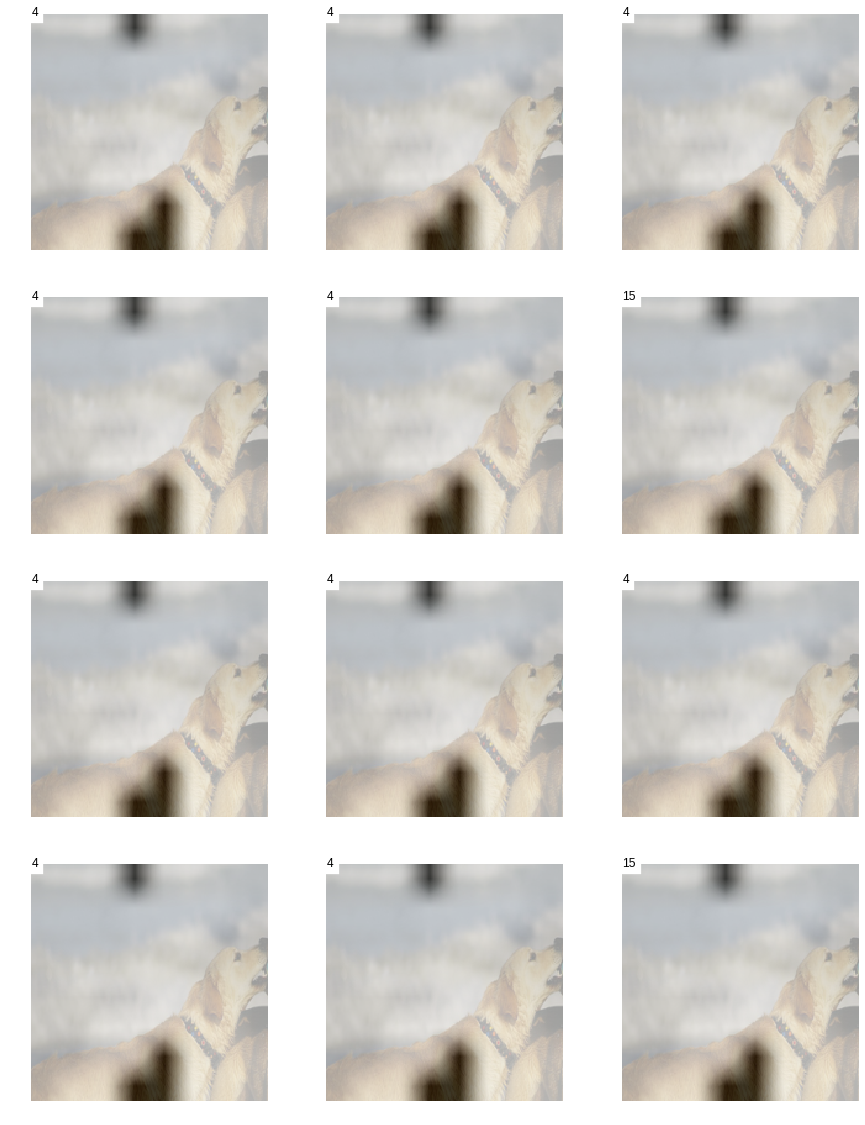

In [0]:
visualize(image_tensors, image_paths, test_dataset.examples[2].image_index)

# Дополнительные материалы

## Статьи
Neural Machine Translation by Jointly Learning to Align and Translate, Bahdanau, 2014 [[pdf]](https://arxiv.org/pdf/1409.0473.pdf)  
Effective Approaches to Attention-based Neural Machine Translation, Luong, 2015 [[arxiv]](http://arxiv.org/abs/1508.04025)  
Show, Attend and Tell: Neural Image Caption Generation with Visual Attention, Xu, 2015 [[arxiv]](https://arxiv.org/abs/1502.03044)

## Блоги
[Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/)  
[Deep Learning for NLP Best Practices, Attention](http://ruder.io/deep-learning-nlp-best-practices/index.html#attention)  
[Attention? Attention!](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)  
[Multi-Modal Methods: Image Captioning (From Translation to Attention)](https://medium.com/mlreview/multi-modal-methods-image-captioning-from-translation-to-attention-895b6444256e)  

## Видео
[Attention в Deep Learning и машинный перевод в очень широком смысле](https://www.youtube.com/watch?v=k63pDjKV3Ew)

# Сдача

[Форма для сдачи](https://goo.gl/forms/RnQN6UrGKdxPxPBG3)  
[Feedback](https://goo.gl/forms/9aizSzOUrx7EvGlG3)